# Sorting Mock Galaxy Observations with Unsupervised Methods
### Bobby Bickley, Phys. 555 2020

In [1]:
#Imports
from six.moves import urllib
from sklearn.decomposition import PCA
from scipy.io import loadmat
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
import itertools
from sklearn import preprocessing
import keras
from IPython.display import clear_output
from sklearn.linear_model import LogisticRegression
from keras.layers import Input, Dense
from keras.models import Model
import itertools
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tarfile
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model
from keras import backend as K
import os, sys
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import cv2
from skimage.transform import resize
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

Using TensorFlow backend.
/Users/robertbickley/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/robertbickley/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/robertbickley/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/robertbickley/anaconda3/l

In [2]:
#PlotLosses class borrowed from class exercises
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="train")
        plt.plot(self.x, self.val_losses, label="validation",linestyle='--')
        plt.legend()
        plt.show();
plot_losses = PlotLosses()

In [3]:
#My own function to grab data from an image file, which is a tarball of the 4 camera angles for a given galaxy
def im_look(filename,cam):
    sci_tar = tarfile.open(filename)
    membs=sci_tar.getmembers()
    im_dat = fits.getdata(sci_tar.extractfile(membs[cam]))
    sci_tar.close()
    return im_dat

In [4]:
#Retrieve galaxy image data from wherever it is stored on your machine
data_dir = '/Users/robertbickley/Documents/UVic/y1/ML/project/sci_ims_1/'
data_files = os.listdir(data_dir)
if '.DS_Store' in data_files: data_files.remove('.DS_Store')
data_files = [data_dir+i for i in data_files]
inp = np.array([resize(im_look(f,c),(128,128)) for f in data_files for c in range(4)])

Please note: to produce the figures in this notebook, I used a smaller dataset of ~4000 images, so that I could complete it in an interactive session. For the results shown in my presentation, I will be using a sample 10x larger than that, ~40,000 images, to get more robust results. Running with 40,000 images is not possible in an interactive session, however.

In [5]:
#normalize
inp = [i-np.amin(i) for i in inp]
inp = [i/np.amax(i) for i in inp]
inp_flat = np.reshape(inp,(-1,16384))

/Users/robertbickley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


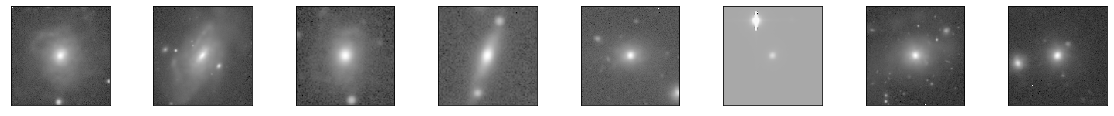

In [6]:
#Visualize thumbnails of a few of the galaxies
n = 8  # how many galaxies we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.log10(np.reshape(inp_flat[i],(128,128))))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [7]:
#Split the data
inp_tr,inp_va = train_test_split(inp_flat,test_size=.2,random_state=0)

In [8]:
#Define a deep, under-complete autoencoder with only dense layers
encoding_dim = 128
# this is our input placeholder
input_img = Input(shape=(16384,))
encoded = Dense(2048, activation='relu')(input_img)
encoded = Dense(512, activation='relu')(encoded)
z = Dense(encoding_dim, activation='relu', name = 'latent_layer')(encoded)
z= keras.layers.BatchNormalization()(z)
decoded = Dense(512, activation='relu')(z)
decoded = Dense(2048, activation='relu')(decoded)
decoded = Dense(16384, activation='sigmoid')(decoded)
# this model maps an input to its encoded representation
encoder = Model(input_img, z)
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              33556480  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
latent_layer (Dense)         (None, 128)               65664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              1050624   
______

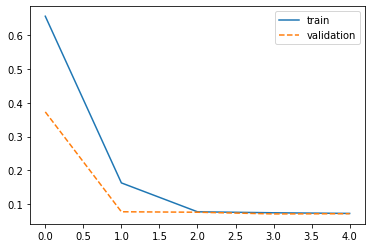

In [9]:
#For this example, only allowing for 5 epochs. Performance does not improve with more epochs. Refer to presentation.
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(inp_tr, inp_tr,
                epochs=5,
                batch_size=32,
                shuffle=True,
                validation_data=(inp_va, inp_va),callbacks=[plot_losses])

In [10]:
#Make dense encoder predictions on the data
decoded_tr = autoencoder.predict(inp_tr)
decoded_va = autoencoder.predict(inp_va)
print('The size of the latent validation set == ', np.shape(decoded_va))

The size of the latent validation set ==  (788, 16384)


/Users/robertbickley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


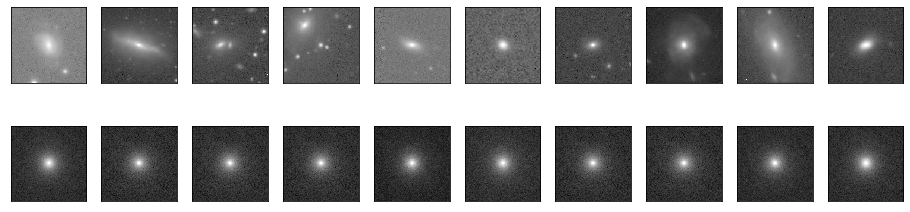

In [11]:
n = 10  # how many digits we will display
plt.figure(figsize=(16,4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.log10(inp_va[i].reshape(128, 128)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(np.log10(decoded_va[i].reshape(128, 128)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
#With the limited success of a dense-only autoencoder, let's try a CNN autoencoder
#Autoencoder CNN
input_img = Input(shape=(128, 128, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
z = MaxPooling2D((2, 2), padding='same', name='latent_layer')(x)
z= keras.layers.BatchNormalization()(z)

x = Conv2D(4, (3, 3), activation='relu', padding='same')(z)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='sigmoid', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# this model maps an input to its encoded representation
encoder = Model(input_img, z)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

autoencoder.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 4)         292       
_________________________________________________________________
latent_layer (MaxPooling2D)  (None, 16, 16, 4)         0         
_______

In [13]:
#Since we will be using the CNN autoencoder for our next steps, we define an encoder-only model.
encoder = Model(input_img,z)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 4)         292       
_________________________________________________________________
latent_layer (MaxPooling2D)  (None, 16, 16, 4)         0         
__________

In [14]:
#Because this model takes 2D input, we un-reshape our data back to its original size.
inp_tr2D = np.reshape(inp_tr, (len(inp_tr), 128, 128, 1))
inp_va2D = np.reshape(inp_va, (len(inp_va), 128, 128, 1))

In [15]:
#Training code is commented out because the model was trained in an earlier session. Repeat training for your data.
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
# autoencoder.fit(inp_tr2D, inp_tr2D,
#                 epochs=100,
#                 batch_size=128,
#                 shuffle=True,
#                 validation_data=(inp_va2D, inp_va2D),callbacks=[plot_losses])
# autoencoder.save_weights('autoenc_model.h5')

#Instead, we load the saved weights from a file
autoencoder.load_weights('autoenc_model.h5')

In [16]:
#Make predictions using the new encoder
encoded_va = encoder.predict(inp_va2D)
encoded_tr = encoder.predict(inp_tr2D)

In [17]:
#Now, we will feed the encoded data into a Kmeans algorithm, first with K=3, as an example.
K = 3
#Change the reshape statement to reflect the sizes of your training and testing set from earlier
kmeans = KMeans(n_clusters=K).fit(encoded_tr.reshape(3152,-1))
Kmean_tr=kmeans.predict(encoded_tr.reshape(3152,-1))
Kmean_va=kmeans.predict(encoded_va.reshape(788,-1))

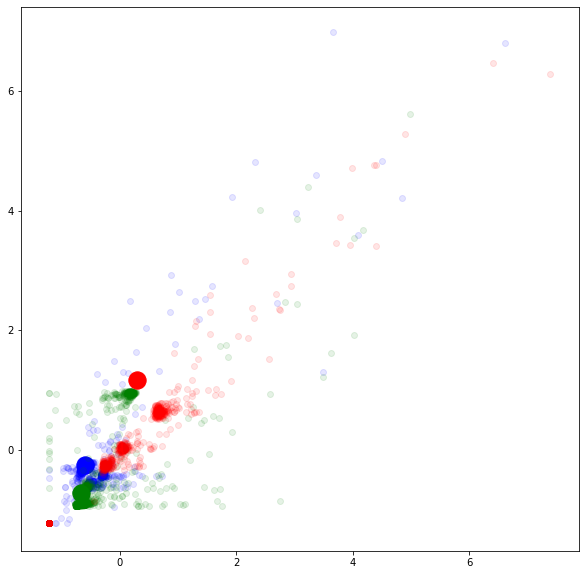

In [18]:
#Data visualization attempt 1: select two features from the data, and plot the centers and distributions of the data
comp_x = 0
comp_y = 1
colors = ['b','g','r','c','m','y','black']
fig1 = plt.figure(figsize=[10,10])
for k1 in range(K):
    plt.scatter(kmeans.cluster_centers_[k1,comp_x],kmeans.cluster_centers_[k1,comp_y],s=300,c=colors[k1],marker='o')
    plt.scatter(encoded_va.reshape(788,-1)[Kmean_va==k1][comp_x],encoded_va.reshape(788,-1)[Kmean_va==k1][comp_y],c=colors[k1],alpha=0.1)
plt.show()

In [19]:
#Data visualization improvement: use T-SNE to project the data onto two dimensions
tsne = TSNE(n_components=2)
tsne.fit(encoded_tr.reshape(3152,-1))
tsne_results_tr= tsne.fit_transform(encoded_tr.reshape(3152,-1))

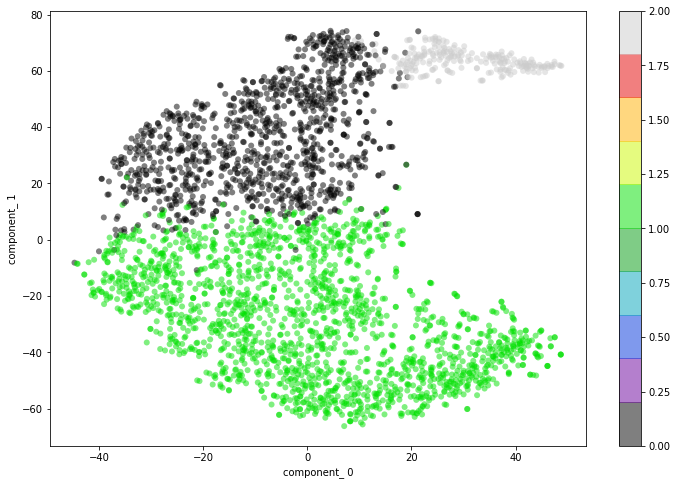

In [20]:
#Make a plot of the T-SNE result
#t-SNE plot
comp_x=0
comp_y=1
plt.figure(figsize=(12,8))
plt.scatter(tsne_results_tr[:,comp_x], tsne_results_tr[:,comp_y], edgecolor='none', alpha=0.5,c=Kmean_tr,cmap=plt.cm.get_cmap('nipy_spectral',10))
plt.xlabel('component_ '+ str(comp_x))
plt.ylabel('component_ '+str(comp_y))
plt.colorbar()
plt.show()

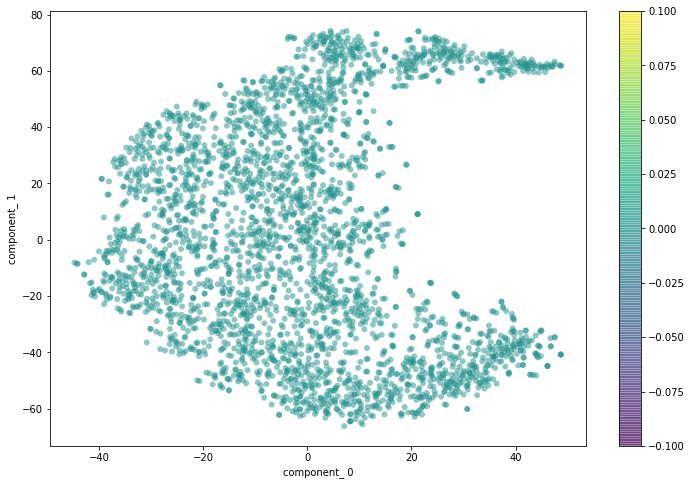

In [21]:
#How do we compare to our naively-defined artifact metric, the zero-flux-pixel fraction?
#Take naive "artifact" statistic of f_zer, and split them into the same two sets as above.
f_zers = [len(np.argwhere(im>1))/(len(im)**2) for im in inp]
fr_tr,fr_va = train_test_split(f_zers,test_size=.2,random_state=0)
#alt t-SNE plot to show separation of naively-defined artifacts
plt.figure(figsize=(12,8))
plt.scatter(tsne_results_tr[:,comp_x], tsne_results_tr[:,comp_y], edgecolor='none', alpha=0.5,c=fr_tr,cmap='viridis')
plt.xlabel('component_ '+ str(comp_x))
plt.ylabel('component_ '+str(comp_y))
plt.colorbar()
plt.show()

/Users/robertbickley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


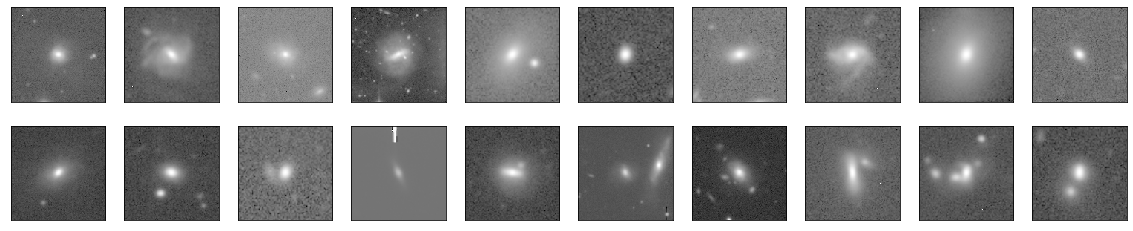

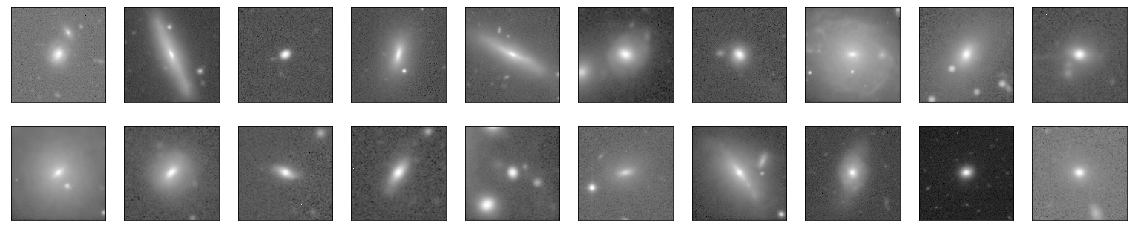

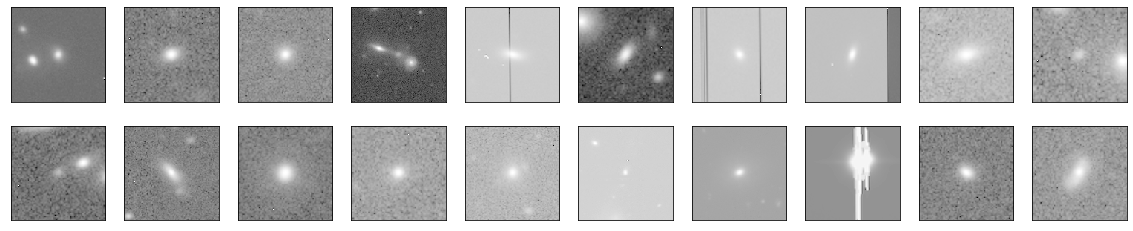

In [22]:
#Let's inspect images that were placed into each of the three classes
for n in range(3):
    fig, axs = plt.subplots(2,10,figsize=(20, 4))
    count = 0
    #Plotting 2x10 images for each Kmean cluster
    for i in range(2):
        for j in range(10):
            plt.gray()
            axs[i][j].imshow(np.log10(np.reshape(inp_tr[Kmean_tr==n][count],(128,128))))
            axs[i][j].get_xaxis().set_visible(False)
            axs[i][j].get_yaxis().set_visible(False)
            count +=1
    plt.show()

With K = 3, the third category (last two rows above) captures the visible artifacts, though with a coarse brush. A larger number of "normal" images are also included.

In [23]:
#Now, we'll repeat the last few steps with our final K-value, 6
K=6
# fit the n first components of pca  by Kmean 
kmeans = KMeans(n_clusters=K).fit(encoded_tr.reshape(3152,-1))
Kmean_tr=kmeans.predict(encoded_tr.reshape(3152,-1))
Kmean_va=kmeans.predict(encoded_va.reshape(788,-1))

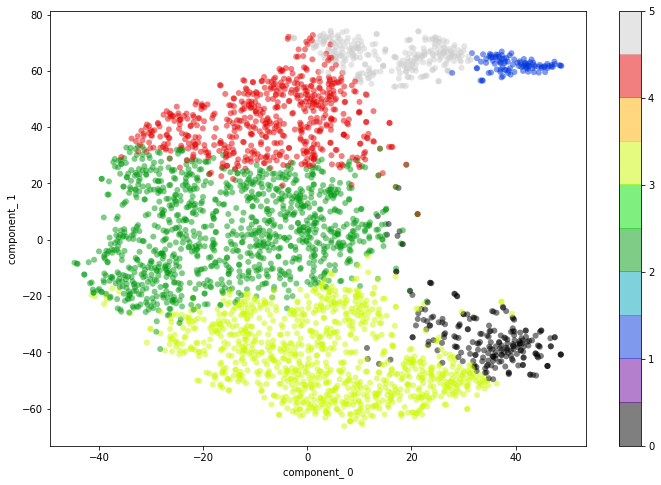

In [24]:
#Improved data visualization method using T-SNE
comp_x=0
comp_y=1
plt.figure(figsize=(12,8))
plt.scatter(tsne_results_tr[:,comp_x], tsne_results_tr[:,comp_y], edgecolor='none', alpha=0.5,c=Kmean_tr,cmap=plt.cm.get_cmap('nipy_spectral',10))
plt.xlabel('component_ '+ str(comp_x))
plt.ylabel('component_ '+str(comp_y))
plt.colorbar()

/Users/robertbickley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


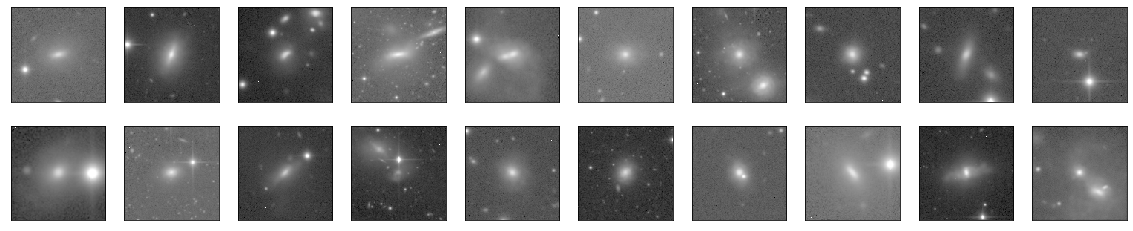

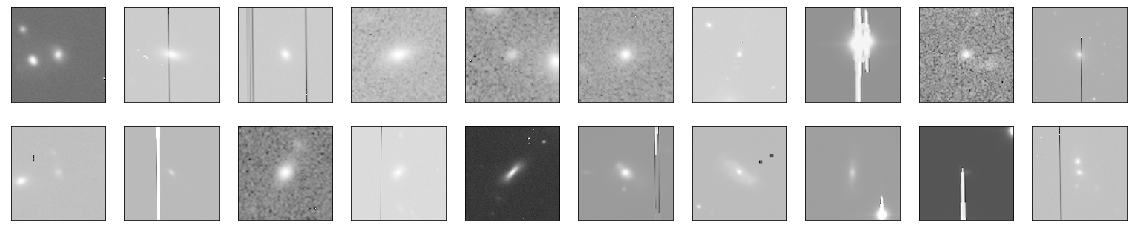

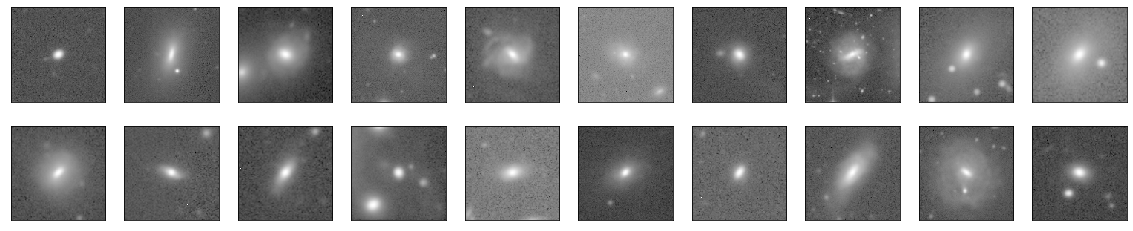

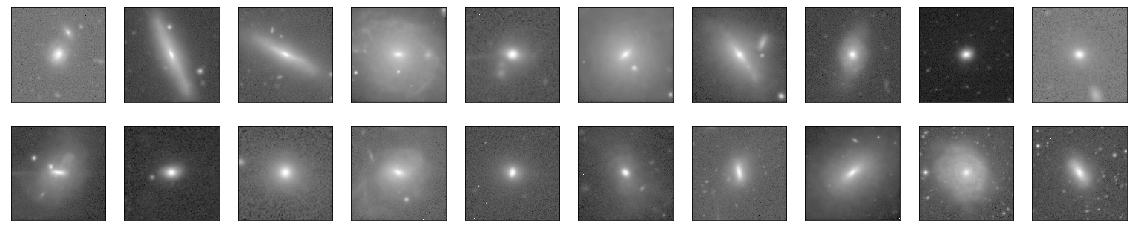

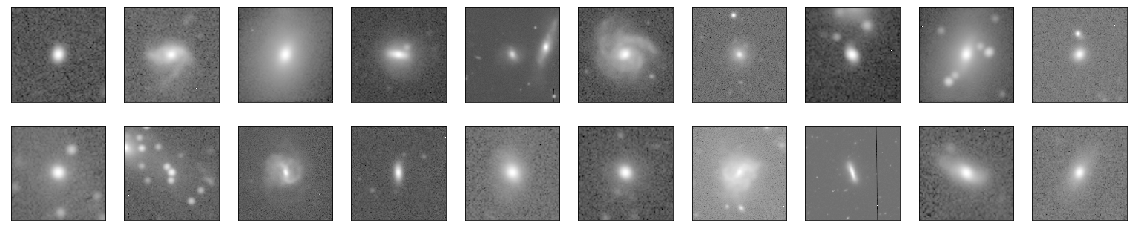

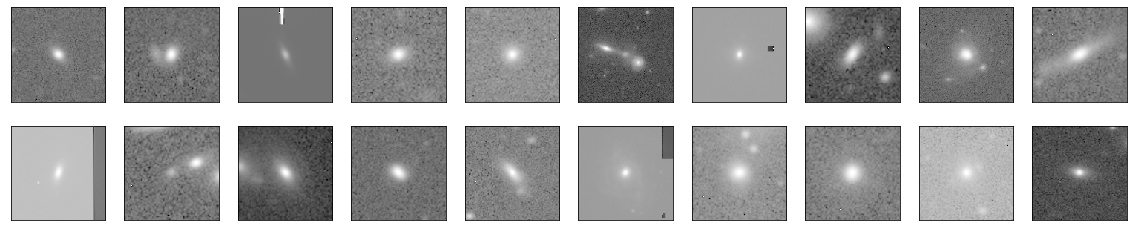

In [25]:
#Once again visually inspecting the Kmeans classifications
for n in range(6):
    fig, axs = plt.subplots(2,10,figsize=(20, 4))
    count = 0
    #Plotting 2x10 images for each Kmean cluster
    for i in range(2):
        for j in range(10):
            plt.gray()
            axs[i][j].imshow(np.log10(np.reshape(inp_tr[Kmean_tr==n][count],(128,128))))
            axs[i][j].get_xaxis().set_visible(False)
            axs[i][j].get_yaxis().set_visible(False)
            count +=1
    plt.show()

With K = 6, there is a small tradeoff, but with net positive results. While a few, less-catastrophic artifact images are included in other categories, the second category (rows 3 and 4 in the image above) contains a much higher density of artifact images than with other categories.